# **Hotel Booking Cancelation**

## **1. Business Problem Understanding**

**Business Problem**

As a data scientist, I will build a machine learning model to predict which customers have the potential to cancel hotel bookings.

**Goals**

Create tools or machine learning models that can be used to predict which customers have the potential to cancel hotel bookings.

**Metric Evaluation**

Because I will focus on customers who have the potential to cancel orders, the focus of the metric is to minimize FN (False Negative) by using Recall to get the highest Recall value.

![gambar hotel](https://wallpapermemory.com/uploads/379/hotel-background-hd-1920x1200-494980.jpg)

## **2. Data Understanding**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import country_converter as coco

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from category_encoders import BinaryEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, recall_score, get_scorer_names, classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [2]:
hotel = pd.read_csv("hotel_bookings.csv")
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| hotel | Object | Hotel Type (Resort or City) |
| is_canceled | Integer | Value indicating if the booking was canceled (1) or not (0) |
| lead_time | Integer | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
| arrival_date_year | Integer | Year of arrival date |
| arrival_date_month | Object | Month of arrival date |
| arrival_date_week_number | Integer | Week number of year for arrival date |
| arrival_date_day_of_month | Integer | Day of arrival date |
| stays_in_weekend_nights | Integer | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| stays_in_week_nights | Integer | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| adults | Integer | Number of adults |
| children | Float | Number of children |
| babies | Integer | Number of babies |
| meal | Object | Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner) |
| country | Object | Country of origin |
| market_segment | Object | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| distribution_channel | Object | Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| is_repeated_guest | Integer | Value indicating if the booking name was from a repeated guest (1) or not (0) |
| previous_cancellations | Integer | Number of previous bookings that were cancelled by the customer prior to the current booking |
| previous_bookings_not_canceled | Integer | Number of previous bookings not cancelled by the customer prior to the current booking |
| reserved_room_type | Object | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| assigned_room_type | Object | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons. |
| booking_changes | Integer | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type | Object | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay. |
| agent | Float | ID of the travel agency that made the booking |
| company | Float | ID of the company/entity that made the booking or responsible for paying the booking. |
| days_in_waiting_list | Integer | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type | Object | Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking |
| adr | Float | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
| required_car_parking_spaces | Integer | Number of car parking spaces required by the customer |
| total_of_special_requests | Integer | Number of special requests made by the customer (e.g. twin bed or high floor) |
| reservation_status | Object |Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why |
| reservation_status_date | Object | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel |

`is_canceled` will be the label or target column to be predicted (dependent variable), and the other column will be predictor variable / independent variable which will predict `is_canceled`.

In [4]:
listItem = []
for col in hotel.columns :
    listItem.append( [col, hotel[col].nunique(), hotel[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,hotel,2,"[Resort Hotel, City Hotel]"
1,is_canceled,2,"[0, 1]"
2,lead_time,479,"[342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68..."
3,arrival_date_year,3,"[2015, 2016, 2017]"
4,arrival_date_month,12,"[July, August, September, October, November, D..."
5,arrival_date_week_number,53,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3..."
6,arrival_date_day_of_month,31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
7,stays_in_weekend_nights,17,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18,..."
8,stays_in_week_nights,35,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12,..."
9,adults,14,"[2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]"


## **3. Data Preprocessing and Feature Engineering**

In analyzing the data, the quality of the data will determine the final result. No matter how good the analysis results are, if the quality of the data is low, the results will be biased or unsatisfactory. Determination of whether the quality of the data is good or not is determined in this process. This process will check for various errors in the data such as missing value, duplicate data, etc. from raw data into data that is ready to be used for further analysis.

### **3.1. Check Missing Value**

In [5]:
listdesc = []
for col in hotel.columns:
    listdesc.append([col,
                     hotel[col].dtypes,
                     hotel[col].isna().sum(),
                     round((hotel[col].isna().sum()/len(hotel)*100),2),
                     hotel[col].nunique(),
                     hotel[col].drop_duplicates().sample(1).values])

pd.DataFrame(listdesc, columns=['Data Features',
                               'Data Types',
                               'Null',
                               'Null Percentage',
                               'Unique',
                               'Unique Sample'])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,hotel,object,0,0.00,2,[City Hotel]
1,is_canceled,int64,0,0.00,2,[1]
2,lead_time,int64,0,0.00,479,[259]
3,arrival_date_year,int64,0,0.00,3,[2017]
4,arrival_date_month,object,0,0.00,12,[August]
5,arrival_date_week_number,int64,0,0.00,53,[28]
6,arrival_date_day_of_month,int64,0,0.00,31,[27]
7,stays_in_weekend_nights,int64,0,0.00,17,[1]
8,stays_in_week_nights,int64,0,0.00,35,[42]
9,adults,int64,0,0.00,14,[5]


There are four columns that have missing values, namely `children`, `country`, `agent`, and `company` columns. Let's look at the distribution.

<AxesSubplot:>

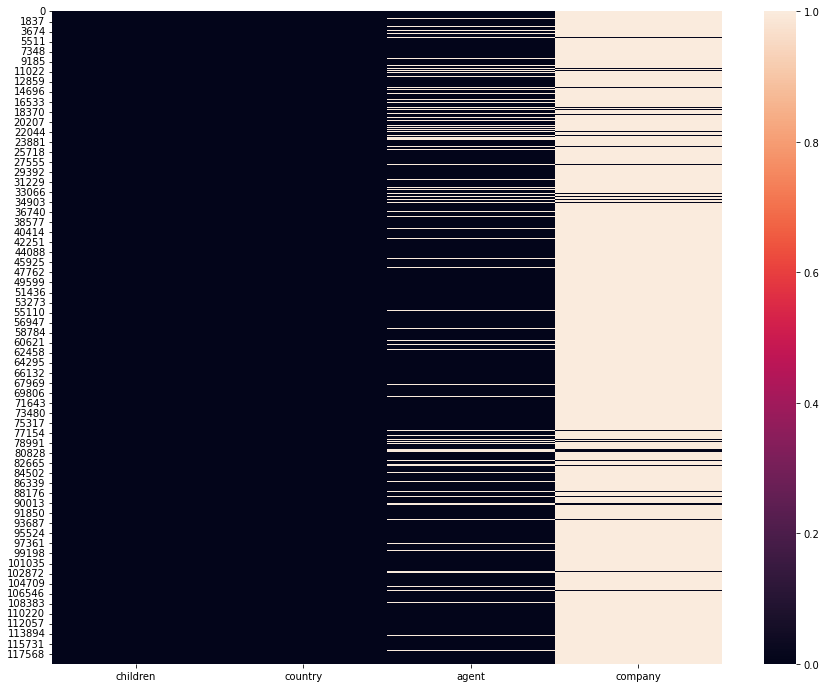

In [6]:
plt.figure(figsize=(15,12))
sns.heatmap(hotel[["children","country", "agent", "company"]].isna())

In [7]:
# np.where(hotel[['children']].isna().any(axis=1))[0]

I will handle missing values from the largest to the smallest.

#### **3.1.1 Handling `company` Column**

If we look from the attribute information, this column uses a numeric code to maintain the privacy of the name of the company making the booking. Therefore I can not change the contents of this column because it is confidential. Given that the number is above 90% then I will delete the column.

In [8]:
hotel = hotel.copy().drop(columns = "company")
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


#### **3.1.2 Handling `agent` Column**

This column also uses a numeric code to maintain the privacy of the agent's name making the booking. Therefore I also can not change the contents of this column because it is confidential. In the end I decided to remove all indexes on this column which had outliers.

In [9]:
hotel.dropna(subset = ["agent"], inplace = True)

#### **3.1.3 Handling `country` and children Column**

In [10]:
listdesc = []
for col in hotel[["children", "country"]]:
    listdesc.append([col,
                     hotel[col].dtypes,
                     hotel[col].isna().sum(),
                     round((hotel[col].isna().sum()/len(hotel)*100),2),
                     hotel[col].nunique(),
                     hotel[col].drop_duplicates().sample(1).values])

pd.DataFrame(listdesc, columns=['Data Features',
                               'Data Types',
                               'Null',
                               'Null Percentage',
                               'Unique',
                               'Unique Sample'])

,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,children,float64,2,0.00,5,[nan]
1,country,object,154,0.15,174,[GHA]


It can be seen from the results above that after deleting the missing value in the `agent` column, the missing value of the two columns is less than 1%. This means that I can also delete indexes that have missing values from both columns.

In [11]:
hotel.dropna(subset = ["children", "country"], inplace = True)

### **3.2 Check Duplicate Data**

The step taken to handle duplicate data is to remove duplicate rows. Duplicate data should be removed as it can affect the performance of the machine learning model created [Reference](https://deepchecks.com/what-is-data-cleaning/), the results of the evaluation of test data can be biased due to information leakage from the data being trained.

In [12]:
print("Amount of duplicate data: ", sum(hotel.duplicated()))
hotel.drop_duplicates(inplace = True)

Amount of duplicate data:  27823


### **3.3 Check Outliers**

The existence of data outliers does affect the results of the machine learning model that we will create. Sometimes the outlier value does not mean the data is bad because it could be that the outlier data contains information that we can use to analyze the data so we don't need to delete it.

In [13]:
def check_outlier(col):
    
    Q1 = np.percentile(col, 25)
    Q3 = np.percentile(col, 75)

    IQR = Q3 - Q1

    batas_bawah = Q1 - (IQR * 1.5)
    batas_atas = Q3 + (IQR * 1.5)

    data_outliers = col[(col < batas_bawah) | (col > batas_atas)]
    return data_outliers

In [14]:
feature_outlier = []
for col in hotel.select_dtypes(['float','int']):
    outliers = check_outlier(hotel[col])
    if len(outliers):
        print(f"Feature",col, "has", len(outliers), "outlier")
        feature_outlier.append(col)
    else:
        print(f"Feature", col, "has no outlier")

Feature is_canceled has no outlier
Feature lead_time has 1769 outlier
Feature arrival_date_year has no outlier
Feature arrival_date_week_number has no outlier
Feature arrival_date_day_of_month has no outlier
Feature stays_in_weekend_nights has 191 outlier
Feature stays_in_week_nights has 1391 outlier
Feature adults has 16684 outlier
Feature children has 7683 outlier
Feature babies has 761 outlier
Feature is_repeated_guest has 1098 outlier
Feature previous_cancellations has 1035 outlier
Feature previous_bookings_not_canceled has 952 outlier
Feature booking_changes has 12500 outlier
Feature agent has no outlier
Feature days_in_waiting_list has 756 outlier
Feature adr has 2246 outlier
Feature required_car_parking_spaces has 5390 outlier
Feature total_of_special_requests has 2337 outlier


Now let's look at the visualization of each numeric data that has outliers. The plot used is the Boxplot type because this type is specifically designed to visualize outlier data.

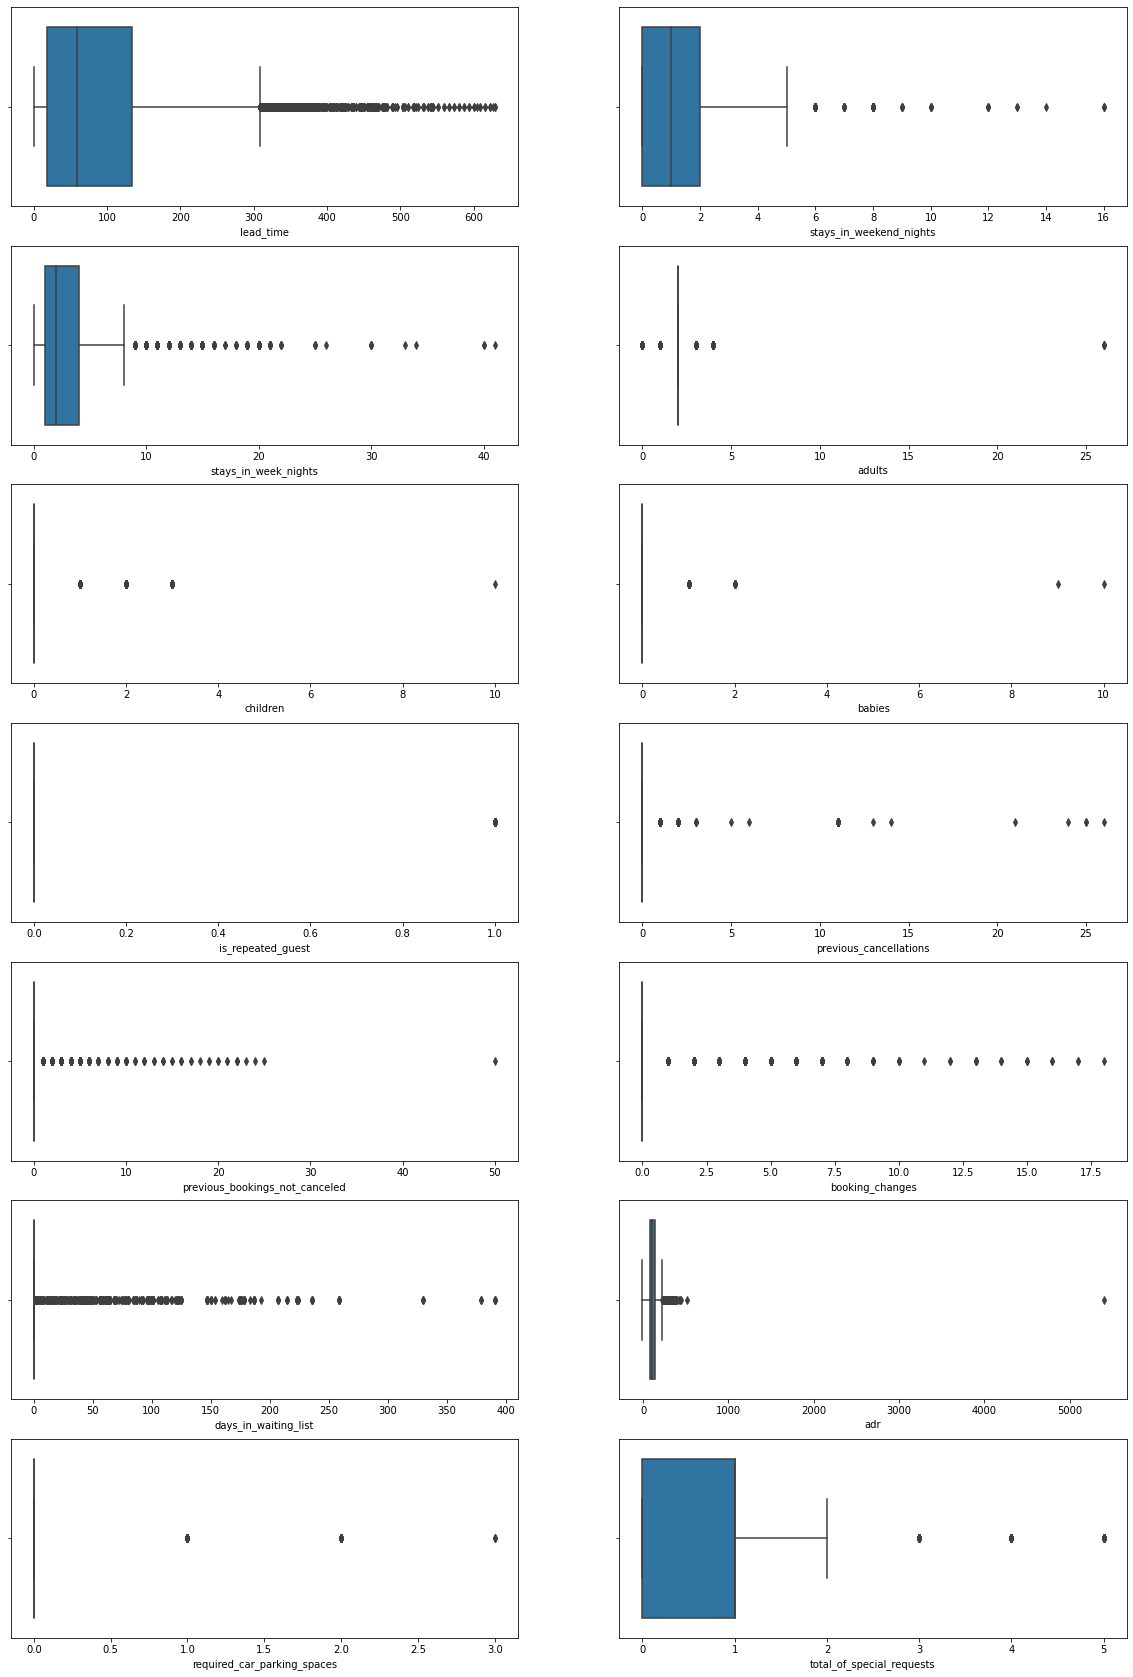

In [15]:
fig, axs = plt.subplots(7, 2, figsize = (20,30))
i = 0
loca = [axs[0,0], axs[0,1], 
axs[1,0], axs[1,1],
axs[2,0], axs[2,1],
axs[3,0], axs[3,1],
axs[4,0], axs[4,1],
axs[5,0], axs[5,1],
axs[6,0], axs[6,1]
]

for col in feature_outlier:
    sns.boxplot(hotel[col], ax = loca[i])
    i += 1
    
plt.show()

In addition to checking the oulier, the plot above can also be used to find anomalous data. The plot above shows that there is anomalous data in the `adr` column where the highest value is at 5400. So I will delete the data because it doesn't make sense.

In [16]:
print(hotel[hotel['adr'] == 5400].index)
hotel.drop(48515, axis = 0, inplace = True)

Int64Index([48515], dtype='int64')


### **3.4 Drop Irrelevant Columns / Feature Selection**

**Attributes Information**

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| hotel | Object | Hotel Type (Resort or City) |
| is_canceled | Integer | Value indicating if the booking was canceled (1) or not (0) |
| lead_time | Integer | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
| arrival_date_year | Integer | Year of arrival date |
| arrival_date_month | Object | Month of arrival date |
| arrival_date_week_number | Integer | Week number of year for arrival date |
| arrival_date_day_of_month | Integer | Day of arrival date |
| stays_in_weekend_nights | Integer | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| stays_in_week_nights | Integer | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| adults | Integer | Number of adults |
| children | Float | Number of children |
| babies | Integer | Number of babies |
| meal | Object | Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner) |
| country | Object | Country of origin |
| market_segment | Object | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| distribution_channel | Object | Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| is_repeated_guest | Integer | Value indicating if the booking name was from a repeated guest (1) or not (0) |
| previous_cancellations | Integer | Number of previous bookings that were cancelled by the customer prior to the current booking |
| previous_bookings_not_canceled | Integer | Number of previous bookings not cancelled by the customer prior to the current booking |
| reserved_room_type | Object | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| assigned_room_type | Object | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons. |
| booking_changes | Integer | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type | Object | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay. |
| agent | Float | ID of the travel agency that made the booking |
| company | Float | ID of the company/entity that made the booking or responsible for paying the booking. |
| days_in_waiting_list | Integer | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type | Object | Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking |
| adr | Float | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
| required_car_parking_spaces | Integer | Number of car parking spaces required by the customer |
| total_of_special_requests | Integer | Number of special requests made by the customer (e.g. twin bed or high floor) |
| reservation_status | Object |Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the hotel of the reason why |
| reservation_status_date | Object | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel |

From the attribute information explanation, we don't need the `arrival_date_year`, `reservation_status`, and `reservation_status_date` columns. For column `arrival_date_year` is not needed because the model to be created will be used at a later date. The `reservation_status` column is not needed because the value is similar to the target variable (`is_cancelled`). Finally, the `reservation_status_date` column is not needed either because it relates to the `reservation_status` column.

In [17]:
hotel_ml = hotel.drop(columns = ["arrival_date_year", "reservation_status", "reservation_status_date"])

### **3.5 Matrix Correlation**

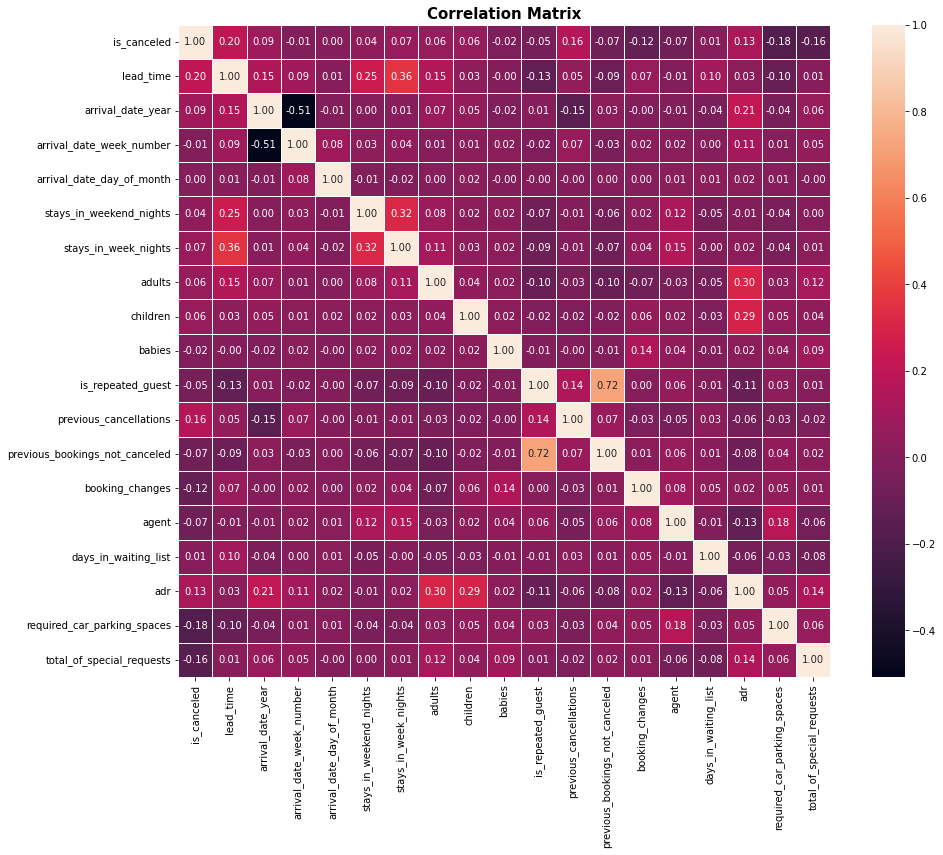

In [18]:
plt.figure(figsize = (15, 12))
palette=sns.diverging_palette(20, 220, n = 256)
corr = hotel.corr(method = 'spearman')
sns.heatmap(corr , annot = True , fmt='.2f', square = True, linewidths = .5)
plt.title('Correlation Matrix', size = 15, weight = 'bold');

### **3.6 Clean Dataset**

For overall data analysis, we will use the `hotel` dataframe. As for machine learning, it uses the `hotel_ml` dataframe.

In [19]:
print(hotel.shape)

(75070, 31)


In [20]:
print(hotel_ml.shape)

(75070, 28)


The final result of the clean data has a total index of 75070 data from the previous 119390 data.

## **4. Data Analysis**

### **4.1 Booking by Region**

Text(0, 0.5, 'Country')

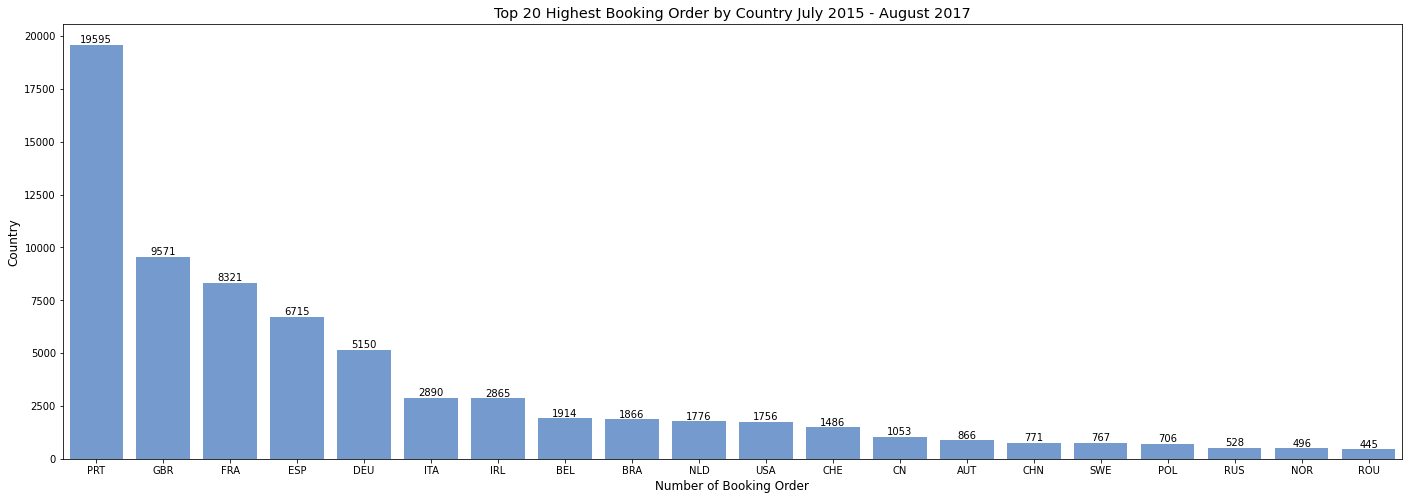

In [24]:
top_20_country = hotel["country"].value_counts().sort_values(ascending=False).head(20)

plt.figure(figsize=(24,8))
plt.title("Top 20 Highest Booking Order by Country July 2015 - August 2017", size = "x-large")
ax = sns.barplot(x = top_20_country.index, y = top_20_country, color='#69d')
ax.bar_label(ax.containers[0])
plt.xlabel("Number of Booking Order", size = "large")
plt.ylabel("Country", size = "large")

It can be seen many of the hotel's countries of origin are dominated by the European continent. To determine what percentage of each continent, I will convert the countries into a continent category.

In [25]:
cc = coco.CountryConverter()
continents = []
for index, row in hotel.iterrows():
    continent = cc.convert([row.country], to='continent')
    continents.append(continent)
cont_df = pd.DataFrame(continents, columns=['continent'])
cont_df = cont_df.value_counts().to_frame().reset_index().rename(columns = {0: "Count"})

TMP not found in ISO3
TMP not found in ISO3
TMP not found in ISO3


In [26]:
cont_df = cont_df.drop(index = 5) # remove unknown continent
cont_df = cont_df.sort_values("continent")

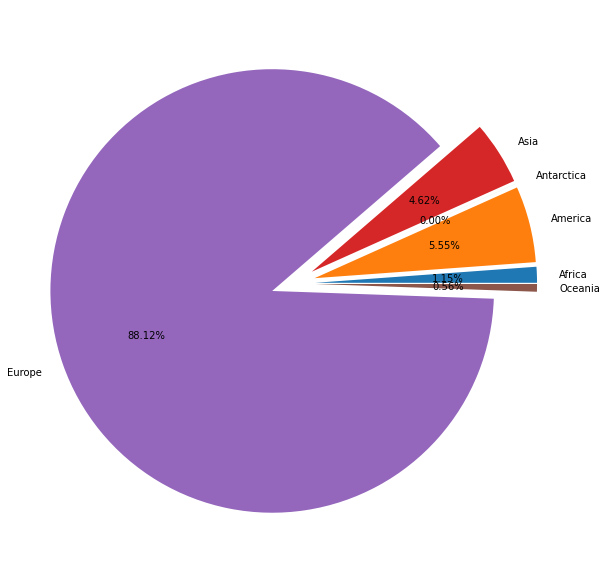

In [27]:
plt.figure(figsize = (14, 8))
plt.pie(cont_df['Count'], labels = cont_df['continent'], autopct = '%.2f%%', explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
plt.tight_layout()
plt.show()  

From the plot above, the European continent dominates the hotels in this dataset

### **4.2 Total Booking Order**

Combine Booking Time Stamp so we can analyze the data by Order Time Stamp

In [28]:
month_number = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
hotel["Month_Number"] = hotel["arrival_date_month"].map(month_number)

In [29]:
hotel["Month_Number"] = hotel["Month_Number"].astype(int).astype(str)
hotel["arrival_date_year"] = hotel["arrival_date_year"].astype(str)
hotel["arrival_date_day_of_month"] = hotel["arrival_date_day_of_month"].astype(str)

In [30]:
hotel["Date_Booking"] = pd.to_datetime(hotel["arrival_date_year"] + "/" + hotel["Month_Number"] + "/" + hotel["arrival_date_day_of_month"])

In [31]:
hotel_resort = hotel[hotel["hotel"] == "Resort Hotel"]
hotel_city = hotel[hotel["hotel"] == "City Hotel"]

hotel_resort = hotel_resort.rename(columns= {
                    "hotel": "Hotel Resort"})
hotel_city = hotel_city.rename(columns= {
                    "hotel": "Hotel City"})

#### **4.2.1 Order by Month**

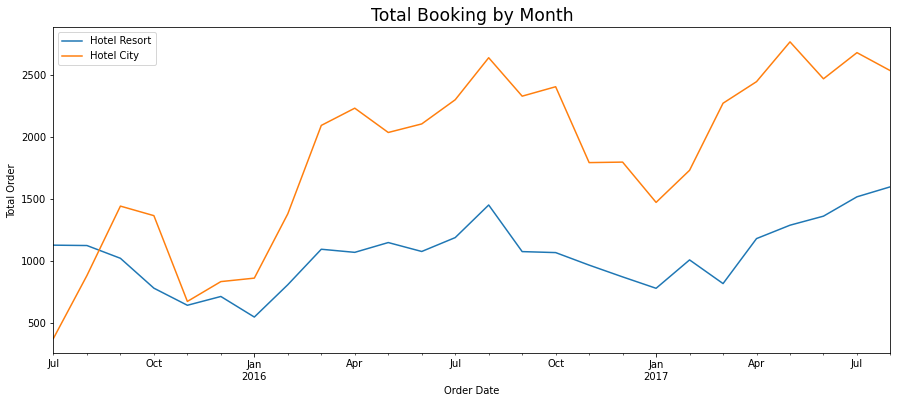

In [32]:
hotel_resort.groupby(hotel_resort['Date_Booking'].dt.to_period('M')).count()['Hotel Resort'].plot(figsize=(15,6))
hotel_city.groupby(hotel_city['Date_Booking'].dt.to_period('M')).count()['Hotel City'].plot(figsize=(15,6))
plt.legend()
plt.title('Total Booking by Month', size = 'xx-large')
plt.xlabel('Order Date')
plt.ylabel('Total Order')
plt.show()

The plot above shows a similar pattern of the two types of hotels. The number of booking orders for both types of hotels increases when summer enters (dominated by the European continent) where this season is the season with the longest holiday. However, after entering the [winter](https://expatexplore.com/blog/winter-europe-5-answers-questions/) (November - February), the number of orders decreased which may be due to the season prefers to be indoors because of the cold weather.

#### **4.2.2 Order with Children**

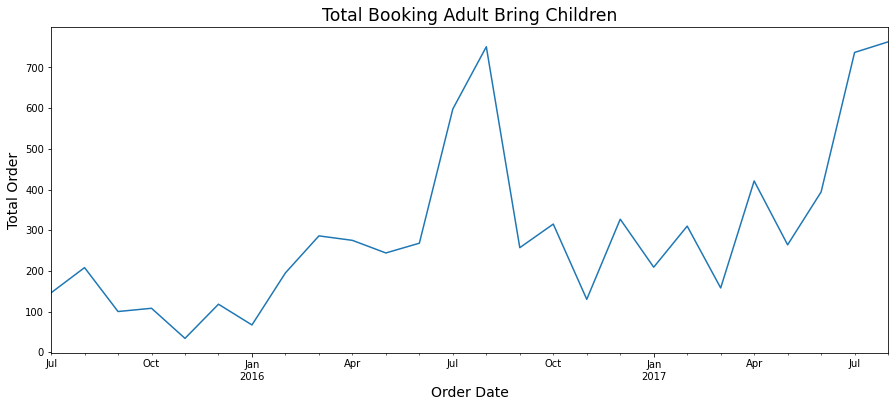

In [33]:
hotel_adult_with_children = hotel[hotel["children"] > 0]
hotel_adult_with_children.groupby(hotel_adult_with_children['Date_Booking'].dt.to_period('M')).count()['hotel'].plot(figsize=(15,6))
plt.title('Total Booking Adult Bring Children', size = 'xx-large')
plt.xlabel('Order Date', size = 14)
plt.ylabel('Total Order', size = 14)
plt.show()

The pattern seen is still the same, where summer is the season where the number of orders increases rapidly. From this plot the hotel can cooperate with tourist attractions around the hotel when staying at this hotel in the summer. Meanwhile, for months with a small number of orders (November to February), the hotel can hold a discount to attract the attention of customers.

### **4.3 Canceled Order**

Now I will observe how the characteristics of customers who cancel orders.

In [34]:
hotel_resort_cancel = hotel_resort[hotel_resort["is_canceled"] == 1]
hotel_city_cancel = hotel_city[hotel_city["is_canceled"] == 1]

#### **4.3.1 Cancel Order by Month**

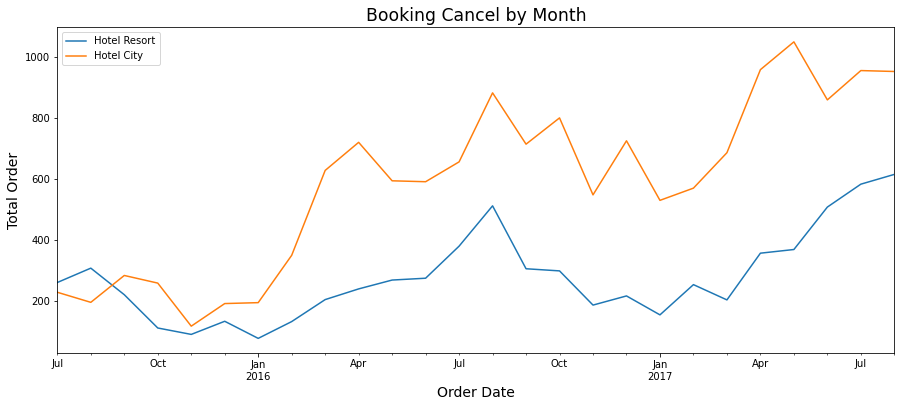

In [35]:
hotel_resort_cancel.groupby(hotel_resort_cancel['Date_Booking'].dt.to_period('M')).count()['Hotel Resort'].plot(figsize=(15,6))
hotel_city_cancel.groupby(hotel_city_cancel['Date_Booking'].dt.to_period('M')).count()['Hotel City'].plot(figsize=(15,6))
plt.legend()
plt.title('Booking Cancel by Month', size = 'xx-large')
plt.xlabel('Order Date', size = 14)
plt.ylabel('Total Order', size = 14)
plt.show()

From the plot above, summer is the season with the most booking orders being cancelled. Let's analyze it by looking at the `deposit_type` column.

#### **4.3.2 Cancel Order by Deposit Type**

In [36]:
hotel_cancel_deposit_type = hotel[hotel["is_canceled"] == 1]["deposit_type"].value_counts().to_frame().reset_index().rename(columns= {"index": "deposit_type", "deposit_type": "count"})
percentage = []
for i in range(0,3):
    pct = (hotel_cancel_deposit_type['count'][i] / hotel_cancel_deposit_type['count'].sum()) * 100
    percentage.append(round(pct, 2))
hotel_cancel_deposit_type['Percentage'] = percentage
hotel_cancel_deposit_type

,deposit_type,count,Percentage
0,No Deposit,21618,96.25
1,Non Refund,823,3.66
2,Refundable,20,0.09


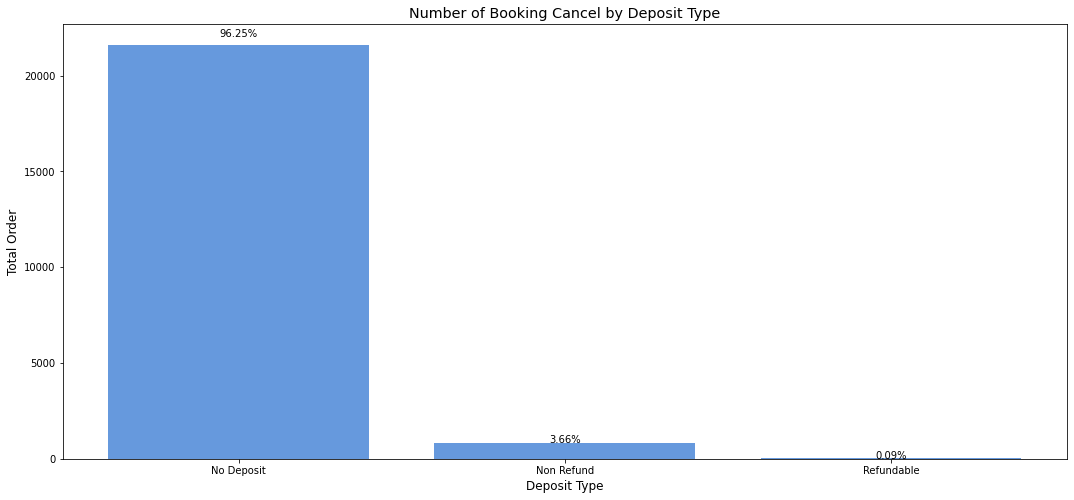

In [44]:
plt.figure(figsize=(18,8))
graph = plt.bar(hotel_cancel_deposit_type["deposit_type"], hotel_cancel_deposit_type["count"], color="#69d")
plt.title("Number of Booking Cancel by Deposit Type", size = "x-large")
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x + width / 2,
             y + height * 1.02,
             str(hotel_cancel_deposit_type.Percentage[i]) + "%",
             ha = "center")
    i += 1
plt.xlabel("Deposit Type", size = "large")
plt.ylabel("Total Order", size = "large")
plt.show()

It can be seen that customers who cancel their orders are dominated by the `No Deposit` type. `No Deposit` as described in the attribute column is one type of booking guarantee that does not require spending money. To avoid customers canceling orders, the hotel through PMS (Property Management System) can add the initial price (the price no need like the room) as a guarantee for the order so that customers who book rooms have to think twice before canceling.

## **4. Modeling**

In modeling we will use a total of 4 types of models, namely 2 base models and 2 ensemble models which will eventually be selected. The models that will be used are as follows:

Base Model:

1. Logistic Regression
2. Decision Tree Classification

Ensemble Model:

1. Random Forest Classification
2. Xtreme Gradient Boosting Classification

In [45]:
lr = LogisticRegression(random_state=0)
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier()

### **4.1 Encoding**

Before doing the modeling, first, we will encode the feature type category. The actual encoding process will be carried out during the modeling process, here we will only create the encoding function. Here we will use the Binary Encoder and One Hot Encoder. The Binary Encoder is used when the category has a large number of uniques, while the One Hot Encoder is used for categories where the number of uniques can still be counted on the fingers.
<br>
<br>
Now we will see the number of unique from each feature which is a category type.

In [46]:
listdesc = []
for col in hotel_ml.select_dtypes('object').columns: # "O"
    listdesc.append([col,
                     hotel_ml[col].dtypes,
                     hotel_ml[col].nunique(),
                     hotel_ml[col].drop_duplicates().sample(1).values])

pd.DataFrame(listdesc, columns=['Data Features',
                               'Data Types',
                               'Unique',
                               'Unique Sample'])

,Data Features,Data Types,Unique,Unique Sample
0,hotel,object,2,[City Hotel]
1,arrival_date_month,object,12,[January]
2,meal,object,5,[SC]
3,country,object,174,[DJI]
4,market_segment,object,7,[Complementary]
5,distribution_channel,object,4,[TA/TO]
6,reserved_room_type,object,8,[H]
7,assigned_room_type,object,10,[K]
8,deposit_type,object,3,[No Deposit]
9,customer_type,object,4,[Transient-Party]


For a category column that has a unique value of only one digit, it will use a one hot encoder, while for a category column that has a unique value of more than 1 digit, it will use a binary encoder. I wouldn't use an ordinal encoder because there are no columns whose values have levels.

In [47]:
one_hot_columns = ["hotel", "meal", "market_segment", "distribution_channel", "reserved_room_type", "deposit_type", "customer_type"]
binary_columns = ["arrival_date_month", "country", "assigned_room_type"]

In [48]:
ct = ColumnTransformer([
    ("One Hot Encoder", OneHotEncoder(drop = "first"), one_hot_columns),
    ("Binary Encoder", BinaryEncoder(), binary_columns)
], remainder = "passthrough")

#### **4.2 Splitting the Data**

Because the model used is a classification, then I need to see the proportion of the target variable.

In [49]:
hotel_ml["is_canceled"].value_counts()

0    52609
1    22461
Name: is_canceled, dtype: int64

In [50]:
hotel_plot = hotel_ml["is_canceled"].copy()
hotel_plot["is_canceled"] = np.where(hotel_ml['is_canceled'] == 1, "Cancel Booking", "Keep Booking")

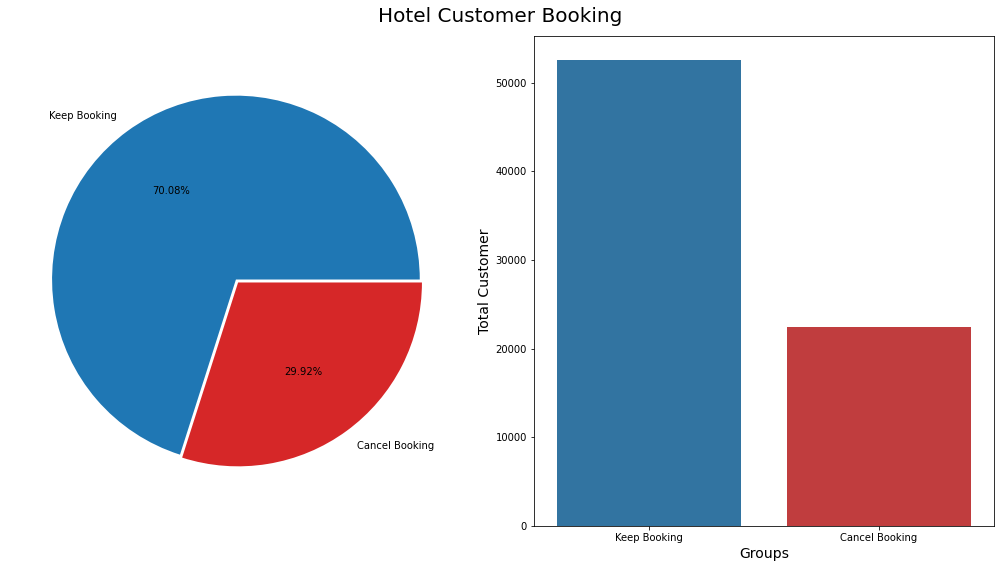

In [51]:

sns.color_palette('pastel')
plt.figure(figsize = (14, 8)).suptitle('Hotel Customer Booking', fontsize=20)
plt.subplot(1,2,1)
plt.pie(hotel_ml['is_canceled'].value_counts(), labels = ['Keep Booking','Cancel Booking'], colors = ['tab:blue','tab:red'], autopct = '%.2f%%',explode=(0.01,0.01))
plt.subplot(1,2,2)
sns.countplot(data = hotel_plot, x = 'is_canceled', palette=['tab:blue',"tab:red"])
plt.xlabel("Groups", size = 14)
plt.ylabel("Total Customer", size = 14)
sns.color_palette('pastel')
plt.tight_layout()
plt.show()  

From the plot above, it can be seen the target variable is imbalance data because the proportions are very different, with the proportion of Keep Booking 70.08% and Cancel Booking 29.92%. Data imbalance can have a negative impact on the machine learning model that will be created, especially when predicting classes with fewer numbers or minority classes, especially since I will focus on customers who cancel bookings. Therefore, I will do resampling to overcome the imbalance case. The use of resampling will be carried out on data splitting to compare the results of the three machine learning models, namely the model that was not resampled, the model with undersampling, and the model with oversampling.
<br>
<br>
Splitting data is divided into 80% train data and 20% test data. The use of stratify is useful to ensure that both data have the same proportion of all targets.

**Normal Split**

In [52]:
X = hotel_ml.drop(['is_canceled'], axis=1)
y = hotel_ml['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state= 0)

print(X_train.shape)
print(y_train.shape)

(60056, 27)
(60056,)


**Undersampling Split**

In [53]:
rus = RandomUnderSampler(random_state = 0)
rus.fit(X_train, y_train)

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print(X_train_under.shape)
print(y_train_under.shape)

(35938, 27)
(35938,)


**Oversampling Split**

In [54]:
ros = RandomOverSampler(random_state = 0)
ros.fit(X_train, y_train)

X_train_over, y_train_over = ros.fit_resample(X_train, y_train)

print(X_train_over.shape)
print(y_train_over.shape)

(84174, 27)
(84174,)


### **4.3 Modeling**

#### **4.3.1 Modeling Data Train**

In [55]:
models = [lr, dt, rf, xgb]

score_recall = []
score_accuracy = []
score_f1 = []

score_recall_under= []
score_accuracy_under= []
score_f1_under= []

score_recall_over= []
score_accuracy_over= []
score_f1_over= []

a = [X_train, X_train_under, X_train_over]
b = [y_train, y_train_under, y_train_over]

c = [score_recall, score_recall_under, score_recall_over]
d = [score_accuracy, score_accuracy_under, score_accuracy_over]
e = [score_f1, score_f1_under, score_f1_over]

for model in models:
    
    cross_val = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
    estimator = Pipeline([
        ('preprocessing', ct),
        ('model', model)
    ])
    for i in range(0, 3):
        # recall score
        model_cv_recall = cross_val_score(
            estimator, 
            a[i], 
            b[i], 
            cv = cross_val, 
            scoring = 'recall', 
            error_score = 'raise'
            )

        c[i].append(model_cv_recall.mean())


        # accuracy score
        model_cv_accuracy = cross_val_score(
            estimator, 
            a[i],
            b[i],
            cv = cross_val, 
            scoring = 'accuracy', 
            error_score = 'raise'
            )

        d[i].append(model_cv_accuracy.mean())

        # f1 score
        model_cv_f1 = cross_val_score(
            estimator, 
            a[i], 
            b[i], 
            cv = cross_val, 
            scoring = 'f1', 
            error_score = 'raise'
            )

        e[i].append(model_cv_f1.mean())

In [56]:
Model_name = ['Logistic Regression', 'Decision Tree Classification', 'Random Forest Classification', 'Extreme Gradient Boost']

train_score = pd.DataFrame({'Model': Model_name,
                            'Score Recall': score_recall,
                            'Score Accuracy': score_accuracy,
                            'Score F1': score_f1,
                            })
percentage = []
for i in range(0,4):
    pct = (train_score['Score Recall'][i] * 100)
    percentage.append(round(pct, 3))
train_score['Percentage Recall'] = percentage

train_score_under = pd.DataFrame({'Model': Model_name,
                            'Score Recall': score_recall_under,
                            'Score Accuracy': score_accuracy_under,
                            'Score F1': score_f1_under,
                            })
percentage_under = []
for i in range(0,4):
    pct = (train_score_under['Score Recall'][i] * 100)
    percentage_under.append(round(pct, 3))
train_score_under['Percentage Recall'] = percentage_under


train_score_over = pd.DataFrame({'Model': Model_name,
                            'Score Recall': score_recall_over,
                            'Score Accuracy': score_accuracy_over,
                            'Score F1': score_f1_over,
                            })
percentage_over = []
for i in range(0,4):
    pct = (train_score_over['Score Recall'][i] * 100)
    percentage_over.append(round(pct, 3))
train_score_over['Percentage Recall'] = percentage_over



**Train Normal**

In [57]:
train_score

,Model,Score Recall,Score Accuracy,Score F1,Percentage Recall
0,Logistic Regression,0.421839,0.755228,0.507161,42.184
1,Decision Tree Classification,0.627803,0.772229,0.622522,62.780
2,Random Forest Classification,0.638711,0.832523,0.695300,63.871
3,Extreme Gradient Boost,0.675997,0.835337,0.710690,67.600


**Train Undersampling**

In [58]:
train_score_under

,Model,Score Recall,Score Accuracy,Score F1,Percentage Recall
0,Logistic Regression,0.731816,0.709861,0.716047,73.182
1,Decision Tree Classification,0.744226,0.742696,0.743085,74.423
2,Random Forest Classification,0.833992,0.811954,0.815997,83.399
3,Extreme Gradient Boost,0.852468,0.815710,0.822236,85.247


**Train Oversampling**

In [59]:
train_score_over

,Model,Score Recall,Score Accuracy,Score F1,Percentage Recall
0,Logistic Regression,0.738732,0.708746,0.717218,73.873
1,Decision Tree Classification,0.932711,0.877611,0.884002,93.271
2,Random Forest Classification,0.949058,0.910733,0.914024,94.906
3,Extreme Gradient Boost,0.885808,0.841887,0.848534,88.581


Now I will plot the results of the three models by only looking at the Recall value.

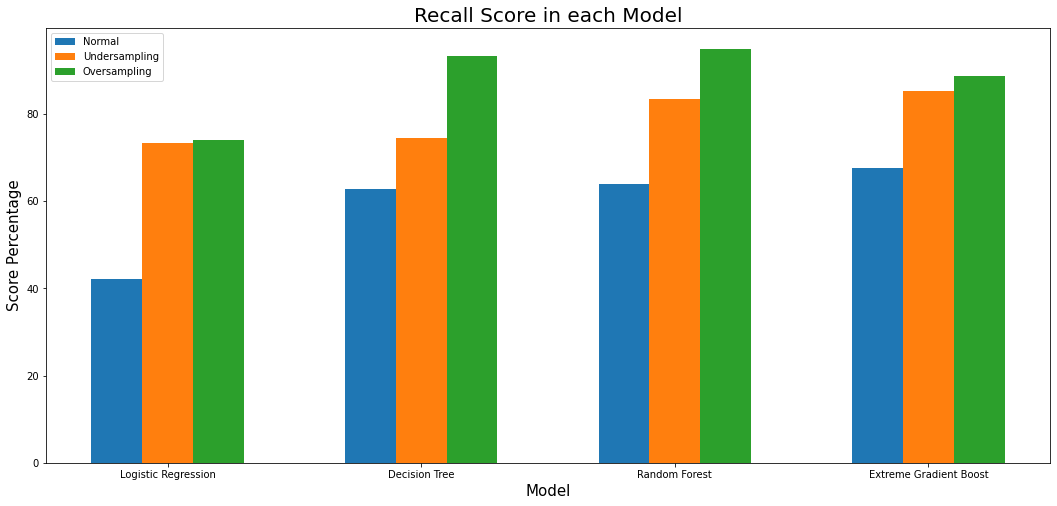

In [60]:
import numpy as np
X = ['Logistic Regression','Decision Tree','Random Forest','Extreme Gradient Boost']
normal = train_score['Percentage Recall']
under = train_score_under['Percentage Recall']
over = train_score_over['Percentage Recall']
  
X_axis = np.arange(len(X))
plt.figure(figsize=(18, 8))
plt.bar(X_axis - 0.2,normal, 0.2, label = 'Normal')
plt.bar(X_axis, under, 0.2,label = 'Undersampling')
plt.bar(X_axis + 0.2,over, 0.2,label = 'Oversampling')
  
plt.xticks(X_axis, X)
plt.title("Recall Score in each Model", size = 20)
plt.xlabel("Model", size = 15)
plt.ylabel("Score Percentage", size = 15)
plt.legend()
plt.show()

From the plot above, it can be seen that the highest recall value is in the data using the Oversampling method.

Here are some characteristics of each resampling technique:

| **Random Undersampling** | **Random Oversampling** |
| --- | --- |
| Vast quantity of data are discarded | Too many data copied |
| Loss information | Overfitting to duplicated ones |
| Loss performance | Poor generalization |

 I will plot again the value of the result of the Oversampling method.

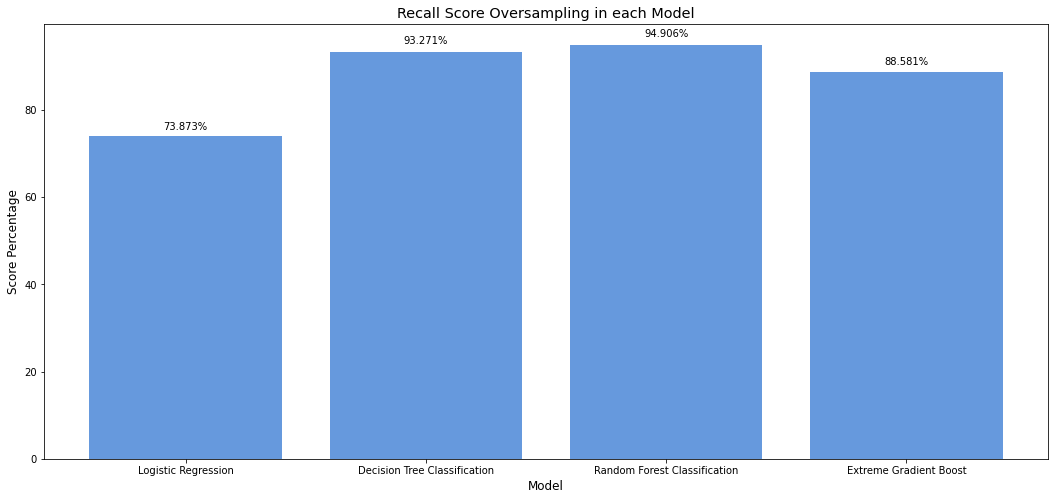

In [66]:
plt.figure(figsize=(18,8))
graph = plt.bar(train_score_over["Model"], train_score_over["Score Recall"] * 100, color="#69d")
plt.title("Recall Score Oversampling in each Model", size = "x-large")
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x + width / 2,
             y + height * 1.02,
             str(train_score_over["Percentage Recall"][i])+"%",
             ha = "center")
    i += 1
plt.xlabel("Model", size = "large")
plt.ylabel("Score Percentage", size = "large")
plt.show()

From the plot above, it can be seen that the best model for train data is the Random Forest Classification.

#### **4.3.2 Modeling Data Test**

We will now incorporate the entire machine learning model oversampling into the test data.

In [67]:
models = [lr, dt, rf, xgb]

score_recall_before_tuning = []

for i in range(0, 4):

    model = Pipeline([
        ('preprocessing', ct),
        ('model', models[i])
        ])

    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_test)
    score_recall_before_tuning.append(recall_score(y_test, y_pred))

In [68]:
Model_name = ['Logistic Regression', 'Decision Tree Classification', 'Random Forest Classification', 'Extreme Gradient Boost']

score_before_tuning = pd.DataFrame({'Model': Model_name,
                            'Score Recall': score_recall_before_tuning
                            })
score_before_tuning

,Model,Score Recall
0,Logistic Regression,0.739092
1,Decision Tree Classification,0.617765
2,Random Forest Classification,0.726848
3,Extreme Gradient Boost,0.853517


After modeling the test data, the best Recall value is the Extreme Gradient Boost model with a value of 0.853517. Next, hyperparameter tuning will be performed.

#### **4.3.3 Hyperparameter Tuning**

At this stage, we will perform hyperparameter tuning to get the best parameters for the selected model (Extreme Gradient Boost). Extreme Gradient Boost has a lot of parameters. If we change all the default parameters of the model, there will be concerns that the model will be overfitting. So that the default parameters that are changed from the model are only 3, namely "max_depth" as the depth of the tree, learning_rate as a modifier of the weight value, and "n_estimators" as the desired number of iterations.

In [399]:
max_depth = list(np.arange(8, 11, 1))
learning_rate = [0.01, 0.05, 0.1, 0.5, 0.9]
n_estimators = list(np.arange(125, 301, 25))

hyperparam_space_xgb = {
    'model__max_depth': max_depth, 
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
}

In [400]:
xgb = XGBClassifier()

estimator_xgb = Pipeline([
        ('preprocessing', ct),
        ('model', xgb)
        ])

crossval = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs = GridSearchCV(
    estimator_xgb, 
    param_grid = hyperparam_space_xgb,
    cv = crossval, 
    scoring = 'recall', 
    n_jobs = -1,
    refit = 'recall'
)

In [ ]:
gs.fit(X_train_over, y_train_over)

From the results of hyperparameter tuning, the following changes are obtained:
1. learning_rate : 0.01
2. max_depth : 9
3. n_estimators : 275

Then we will enter the parameter changes into the model and try again on the test data.

#### **4.3.4 Test Model after Hyperparameter Tuning**

In [69]:
xgb_tuned = XGBClassifier(learning_rate = 0.01, max_depth = 9, n_estimators = 275)

score_recall_after_tuning = []

model = Pipeline([
    ('preprocessing', ct),
    ('model', xgb_tuned)
    ])

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
score_recall_after_tuning.append(recall_score(y_test, y_pred))
score_recall_after_tuning

[0.8688780053428317]

In [82]:
score_plot = pd.DataFrame({'Model': ["XGB Before Tuning", "XGB After Tuning"],
                            'Score_Recall': [score_before_tuning.iloc[3][1], score_recall_after_tuning[0]]
                            })
percentage_score_compare = []
for i in range(0,2):
    pct = (score_plot['Score_Recall'][i] * 100)
    percentage_score_compare.append(round(pct, 2))
score_plot['Percentage_Score'] = percentage_score_compare

score_plot

,Model,Score_Recall,Percentage_Score
0,XGB Before Tuning,0.853517,85.35
1,XGB After Tuning,0.868878,86.89


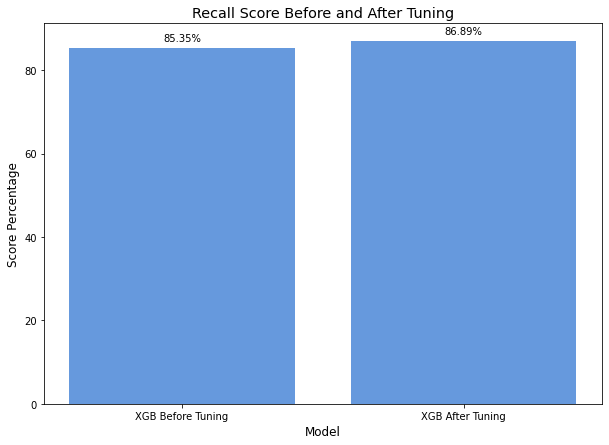

In [81]:
plt.figure(figsize=(10,7))
graph = plt.bar(score_plot["Model"], score_plot["Score_Recall"] * 100, color="#69d")
plt.title("Recall Score Before and After Tuning", size = "x-large")
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x + width / 2,
             y + height * 1.02,
             str(score_plot["Percentage_Score"][i])+"%",
             ha = "center")
    i += 1
plt.xlabel("Model", size = "large")
plt.ylabel("Score Percentage", size = "large")
plt.show()

After tuning, there is an increase in the Recall value. So this model is able to detect customers who cancel bookings by 86.89%.

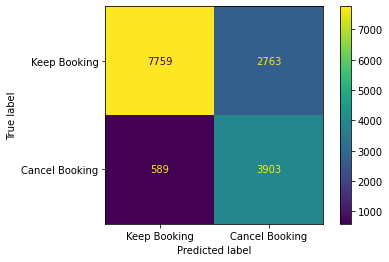

In [737]:

cm = confusion_matrix(y_test, y_pred)
X_cm = ["Keep Booking", "Cancel Booking"]
X_axis_cm = [0, 1]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks(X_axis_cm, X_cm)
plt.yticks(X_axis_cm, X_cm)
plt.show()

The plot above is the confusion matrix of the model that has been made. Recall earned (86.89%) was obtained from 3903 / (3903 + 589).

In [743]:
# Export model

# cancelation_model = model.fit(X_train_over, y_train_over)
# pickle.dump(cancelation_model, open('Model_Hotel_Booking_cancelation.sav', 'wb'))

# Thank You